In [1]:
import pandas as pd
import numpy as np


# for Modelling
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense

from tensorflow.keras.models import load_model

# for Evaluation
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.metrics import mean_absolute_percentage_error


In [2]:
df= pd.read_csv('bx_t1.csv')
df

,Time id,Material,Quantity,Total_Value,Material_Id
0,1,C01-100100,4.0,11560.00,108
1,1,C06-501311,31.0,36731.17,719
2,1,C06-700217,2.0,25900.00,797
3,1,C07-500328,22.0,44702.25,884
4,1,C37-000235,7.0,23828.07,1663
...,...,...,...,...,...
890,38,S12-160336,3.0,39648.85,14447
891,38,S12-160337,3.0,45048.86,14448
892,38,S23-100109,13.0,71666.86,8594
893,38,S31-020101,317.0,65936.00,9207


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense

# Function to build and train RNN models
def build_and_train_model(model_type, X_train, y_train):
    model = Sequential()
    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'GRU':
        model.add(GRU(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'LSTM':
        model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    return model

# Initialize an empty DataFrame to store the forecast results
forecast_df = pd.DataFrame(columns=['Time id', 'Material id', 'Model', 'Actual Quantity', 'Forecasted', 'MAE', 'MAPE', 'R2'])

# Iterate over each material id
for material_id in df['Material_Id'].unique():
    print(f"Forecasting for Material ID: {material_id}")

    # Filter data for the current material id
    material_data = df[df['Material_Id'] == material_id]

    # Split data into train and test sets
    train = material_data[(material_data['Time id'] >= 13) & (material_data['Time id'] <= 26)]
    test = material_data[material_data['Time id'] == 27]

    # Check if both train and test sets have at least one sample
    if len(train) == 0 or len(test) == 0:
        print(f"Skipping Material ID: {material_id} due to empty train or test set.")
        continue

    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train[['Quantity']])
    test_scaled = scaler.transform(test[['Quantity']])

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(train_scaled, (train_scaled.shape[0], 1, 1))
    X_test = np.reshape(test_scaled, (test_scaled.shape[0], 1, 1))
    y_train = train_scaled[:, 0]  # Target variable is Quantity

    # Iterate over each model type
    for model_type in ['SimpleRNN', 'GRU', 'LSTM']:
        print(f"Forecasting with {model_type} model for Material ID: {material_id}")

        # Build and train model
        model = build_and_train_model(model_type, X_train, y_train)

        # Forecast for the test set
        forecasted_values = model.predict(X_test)
        forecasted_values_inv = scaler.inverse_transform(forecasted_values)

        # Get actual quantity for the test set
        actual_quantity = test['Quantity'].values[0]

        # Calculate MAE and MAPE
        mae = mean_absolute_error([actual_quantity], forecasted_values_inv[0])
        mape = mean_absolute_percentage_error([actual_quantity], forecasted_values_inv[0])

        # Calculate R²
        mse = mean_squared_error([actual_quantity], forecasted_values_inv[0])
        r2 = 1 - (mse / (actual_quantity ** 2))  # Simplified R² calculation

        # Append results to the dataframe
        forecast_df = forecast_df.append({
            'Time id': 27,
            'Material id': material_id,
            'Model': model_type,
            'Actual Quantity': actual_quantity,
            'Forecasted': forecasted_values_inv[0][0],
            'MAE': mae,
            'MAPE': mape,
            'R2': r2
        }, ignore_index=True)

# Display the forecast results dataframe
print(forecast_df)



Forecasting for Material ID: 108
Forecasting with SimpleRNN model for Material ID: 108


C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Forecasting with GRU model for Material ID: 108


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Forecasting with LSTM model for Material ID: 108


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Forecasting for Material ID: 719
Forecasting with SimpleRNN model for Material ID: 719


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Forecasting with GRU model for Material ID: 719


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Forecasting with LSTM model for Material ID: 719


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Forecasting for Material ID: 797
Forecasting with SimpleRNN model for Material ID: 797


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Forecasting with GRU model for Material ID: 797


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Forecasting with LSTM model for Material ID: 797


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Forecasting for Material ID: 884
Forecasting with SimpleRNN model for Material ID: 884


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Forecasting with GRU model for Material ID: 884


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Forecasting with LSTM model for Material ID: 884


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Forecasting for Material ID: 1663
Forecasting with SimpleRNN model for Material ID: 1663


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Forecasting with GRU model for Material ID: 1663


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Forecasting with LSTM model for Material ID: 1663


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Forecasting for Material ID: 1664
Forecasting with SimpleRNN model for Material ID: 1664


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Forecasting with GRU model for Material ID: 1664


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Forecasting with LSTM model for Material ID: 1664


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Forecasting for Material ID: 1692
Forecasting with SimpleRNN model for Material ID: 1692


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Forecasting with GRU model for Material ID: 1692


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Forecasting with LSTM model for Material ID: 1692


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Forecasting for Material ID: 1715
Forecasting with SimpleRNN model for Material ID: 1715


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Forecasting with GRU model for Material ID: 1715


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Forecasting with LSTM model for Material ID: 1715


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Forecasting for Material ID: 1716
Forecasting with SimpleRNN model for Material ID: 1716


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Forecasting with GRU model for Material ID: 1716


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Forecasting with LSTM model for Material ID: 1716


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Forecasting for Material ID: 1732
Forecasting with SimpleRNN model for Material ID: 1732


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Forecasting with GRU model for Material ID: 1732


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Forecasting with LSTM model for Material ID: 1732


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Forecasting for Material ID: 2600
Forecasting with SimpleRNN model for Material ID: 2600


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Forecasting with GRU model for Material ID: 2600


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Forecasting with LSTM model for Material ID: 2600


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Forecasting for Material ID: 2865
Forecasting with SimpleRNN model for Material ID: 2865


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Forecasting with GRU model for Material ID: 2865


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Forecasting with LSTM model for Material ID: 2865


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Forecasting for Material ID: 2866
Forecasting with SimpleRNN model for Material ID: 2866


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Forecasting with GRU model for Material ID: 2866


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Forecasting with LSTM model for Material ID: 2866


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Forecasting for Material ID: 3282
Forecasting with SimpleRNN model for Material ID: 3282


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Forecasting with GRU model for Material ID: 3282


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Forecasting with LSTM model for Material ID: 3282


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Forecasting for Material ID: 5180
Forecasting with SimpleRNN model for Material ID: 5180


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Forecasting with GRU model for Material ID: 5180


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Forecasting with LSTM model for Material ID: 5180


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Forecasting for Material ID: 5913
Forecasting with SimpleRNN model for Material ID: 5913


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Forecasting with GRU model for Material ID: 5913


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Forecasting with LSTM model for Material ID: 5913


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Forecasting for Material ID: 6323
Forecasting with SimpleRNN model for Material ID: 6323


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Forecasting with GRU model for Material ID: 6323


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Forecasting with LSTM model for Material ID: 6323


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Forecasting for Material ID: 6543
Forecasting with SimpleRNN model for Material ID: 6543


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Forecasting with GRU model for Material ID: 6543


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Forecasting with LSTM model for Material ID: 6543


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Forecasting for Material ID: 7906
Forecasting with SimpleRNN model for Material ID: 7906


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Forecasting with GRU model for Material ID: 7906


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Forecasting with LSTM model for Material ID: 7906


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Forecasting for Material ID: 7939
Forecasting with SimpleRNN model for Material ID: 7939


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Forecasting with GRU model for Material ID: 7939


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Forecasting with LSTM model for Material ID: 7939


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Forecasting for Material ID: 8594
Forecasting with SimpleRNN model for Material ID: 8594


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Forecasting with GRU model for Material ID: 8594


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Forecasting with LSTM model for Material ID: 8594


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Forecasting for Material ID: 9207
Forecasting with SimpleRNN model for Material ID: 9207


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Forecasting with GRU model for Material ID: 9207


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Forecasting with LSTM model for Material ID: 9207


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Forecasting for Material ID: 13739
Forecasting with SimpleRNN model for Material ID: 13739


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Forecasting with GRU model for Material ID: 13739


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Forecasting with LSTM model for Material ID: 13739


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Forecasting for Material ID: 14447
Forecasting with SimpleRNN model for Material ID: 14447


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Forecasting with GRU model for Material ID: 14447


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Forecasting with LSTM model for Material ID: 14447


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Forecasting for Material ID: 14448
Forecasting with SimpleRNN model for Material ID: 14448


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Forecasting with GRU model for Material ID: 14448


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Forecasting with LSTM model for Material ID: 14448


C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({
C:\Users\sohan\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
   Time id Material id      Model  Actual Quantity  Forecasted       MAE  \
0       27         108  SimpleRNN             19.0   19.339800  0.339800   
1       27         108        GRU             19.0   17.378073  1.621927   
2       27         108       LSTM             19.0   15.046562  3.953438   
3       27         719  SimpleRNN             38.0   37.599350  0.400650   
4       27         719        GRU             38.0   34.006836  3.993164   
..     ...         ...        ...              ...         ...       ...   
70      27       14447        GRU              9.0   12.256654  3.256654   
71      27       14447       LSTM              9.0   12.934917  3.934917   
72      27       14448  SimpleRNN              9.0    9.445990  0.445990   
73      27       14448        GRU              9.0   12.700527  3.700527   
74      27       14448       LSTM              9.0   13.239992  4.239992   

        MAPE        R2  
0   0.017884  0.999680 

C:\Users\sohan\AppData\Local\Temp\ipykernel_23432\1613537058.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append({


In [4]:
# Group forecast results by model
grouped_results = forecast_df.groupby('Model')

# Calculate overall MAE, MAPE, and R2 scores for each model
for model_type, group in grouped_results:
    overall_mae = group['MAE'].mean()
    overall_mape = group['MAPE'].mean()
    overall_r2 = group['R2'].mean()
    
    # Print the overall scores for the current model
    print(f"Overall scores for {model_type} model:")
    print("Overall MAE:", overall_mae)
    print("Overall MAPE:", overall_mape)
    print("Overall R2:", overall_r2)
    print()

Overall scores for GRU model:
Overall MAE: 9.409138402938844
Overall MAPE: 0.30249294907305
Overall R2: 0.8179858072719399

Overall scores for LSTM model:
Overall MAE: 10.717393016815185
Overall MAPE: 0.3990094081590614
Overall R2: 0.7104320836545389

Overall scores for SimpleRNN model:
Overall MAE: 5.62644211769104
Overall MAPE: 0.1691051818481055
Overall R2: 0.9247389753150869



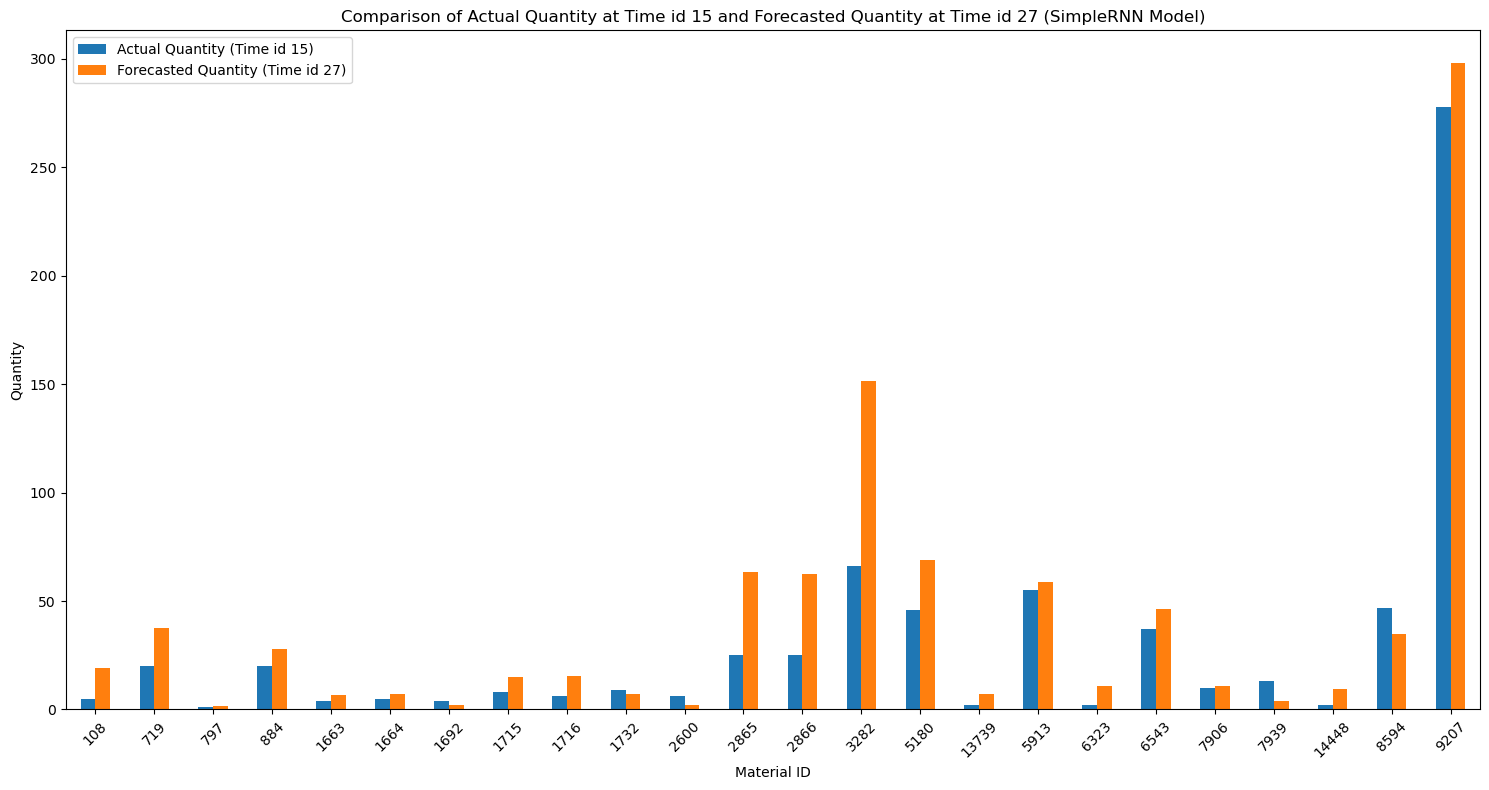

In [5]:
import matplotlib.pyplot as plt

# Filter df for Time id 27
actual_quantities = df[df['Time id'] == 15][['Material_Id', 'Quantity']]
actual_quantities = actual_quantities.set_index('Material_Id')

# Filter forecast_df for Time id 27 and SimpleRNN model
forecasted_quantities = forecast_df[(forecast_df['Time id'] == 27) & (forecast_df['Model'] == 'SimpleRNN')][['Material id', 'Forecasted']]
forecasted_quantities = forecasted_quantities.rename(columns={'Material id': 'Material_Id'})
forecasted_quantities = forecasted_quantities.set_index('Material_Id')

# Merge actual and forecasted quantities
merged_df = actual_quantities.join(forecasted_quantities, how='inner', lsuffix='_actual', rsuffix='_forecasted')

# Plotting
merged_df.plot(kind='bar', figsize=(15, 8))
plt.xlabel('Material ID')
plt.ylabel('Quantity')
plt.title('Comparison of Actual Quantity at Time id 15 and Forecasted Quantity at Time id 27 (SimpleRNN Model)')
plt.xticks(rotation=45)
plt.legend(['Actual Quantity (Time id 15)', 'Forecasted Quantity (Time id 27)'])
plt.tight_layout()
plt.show()

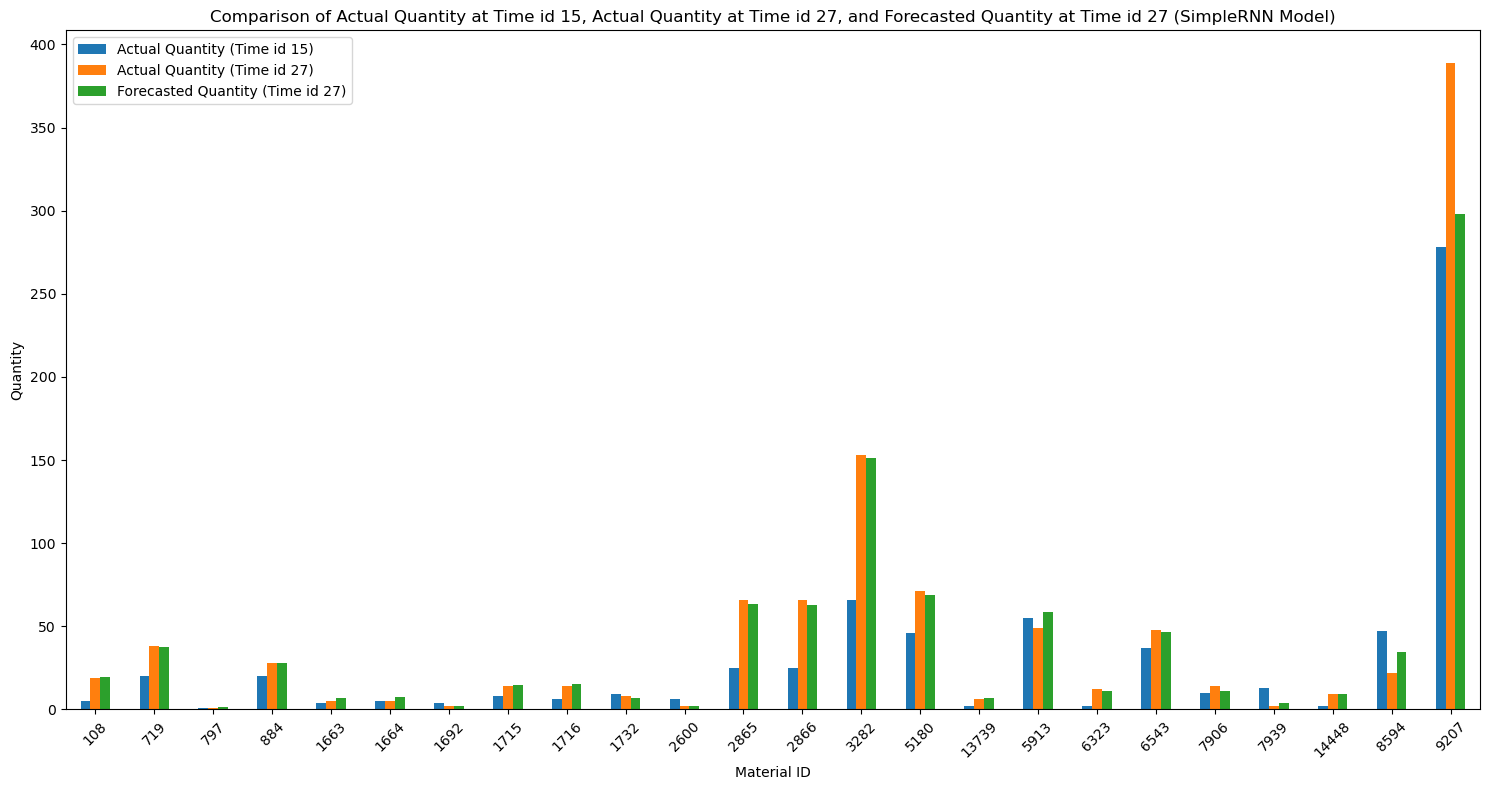

In [6]:
import matplotlib.pyplot as plt

# Filter df for Time id 15
actual_quantities_15 = df[df['Time id'] == 15][['Material_Id', 'Quantity']]
actual_quantities_15 = actual_quantities_15.set_index('Material_Id')

# Filter df for Time id 27
actual_quantities_27 = df[df['Time id'] == 27][['Material_Id', 'Quantity']]
actual_quantities_27 = actual_quantities_27.set_index('Material_Id')

# Filter forecast_df for Time id 27 and SimpleRNN model
forecasted_quantities = forecast_df[(forecast_df['Time id'] == 27) & (forecast_df['Model'] == 'SimpleRNN')][['Material id', 'Forecasted']]
forecasted_quantities = forecasted_quantities.rename(columns={'Material id': 'Material_Id'})
forecasted_quantities = forecasted_quantities.set_index('Material_Id')

# Merge actual quantities at Time id 15, Time id 27, and forecasted quantities
merged_df = actual_quantities_15.join(actual_quantities_27, how='inner', lsuffix='_actual_15', rsuffix='_actual_27')
merged_df = merged_df.join(forecasted_quantities, how='inner')

# Plotting
merged_df.plot(kind='bar', figsize=(15, 8))
plt.xlabel('Material ID')
plt.ylabel('Quantity')
plt.title('Comparison of Actual Quantity at Time id 15, Actual Quantity at Time id 27, and Forecasted Quantity at Time id 27 (SimpleRNN Model)')
plt.xticks(rotation=45)
plt.legend(['Actual Quantity (Time id 15)', 'Actual Quantity (Time id 27)', 'Forecasted Quantity (Time id 27)'])
plt.tight_layout()
plt.show()
